In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.optimizers import SGD
import shap
import matplotlib.pyplot as plt
import seaborn as sns

Original Training Data Distribution:
Training_Program
0    23
2    21
3    20
1    18
4    16
5    15
6    10
7    10
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
3    23
5    23
4    23
1    23
6    23
2    23
0    23
7    23
Name: count, dtype: int64
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1397 - loss: 2.5556 - val_accuracy: 0.1892 - val_loss: 2.1105
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1059 - loss: 2.3299 - val_accuracy: 0.1081 - val_loss: 2.0604
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1843 - loss: 2.0764 - val_accuracy: 0.1081 - val_loss: 2.0086
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2269 - loss: 2.0605 - val_accuracy: 0.0000e+00 - val_loss: 1.9363
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2021 - loss: 2.0630 - val_accuracy: 0.0541 - val_loss: 1.9018
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2143 - los

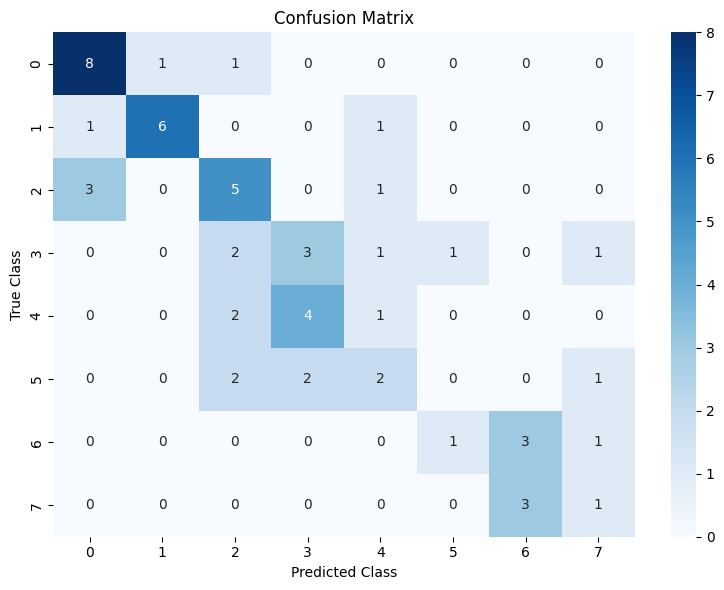

In [2]:
# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program","surgeries","chronic_conditions"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=12)  # random_state for consistency
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Create a model with the new balanced data
# One-hot encode the target variable
y_train_resampled_encoded = to_categorical(y_train_resampled, num_classes=len(y.unique()))
y_test_encoded = to_categorical(y_test, num_classes=len(y.unique()))

# Define the model
model = Sequential([
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.5),
    Dense(len(y.unique()), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.8),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled_encoded,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

# Print test results
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_encoded.argmax(axis=1)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()



In [3]:
# Convert the model into a SHAP explainer
explainer = shap.GradientExplainer(model, X_train[:100])

# Özellik bazlı SHAP değerlerini hesapla
shap_values = explainer(X_test[:100])

# SHAP değerlerini DataFrame'e dönüştür ve ortalama mutlak değerlerini hesapla
shap_values_mean = pd.DataFrame(shap_values.values, columns=X.columns).abs().mean().sort_values(ascending=False)

# Özellik önem sırasını tablo olarak çıkar
shap_feature_importance = pd.DataFrame({
    'Feature': shap_values_mean.index,  # Özellik isimleri
    'Mean Absolute SHAP Value': shap_values_mean.values  # Ortalama mutlak SHAP değerleri
})

# İlk 10 özelliği göster
print(shap_feature_importance.head(10))

# Bar grafiği ile görselleştir
plt.figure(figsize=(10, 6))
shap_values_mean.plot(kind='bar')
plt.title("Feature Importance (Mean Absolute SHAP Values)")
plt.xlabel("Features")
plt.ylabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

C:\Users\licop\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(58, 19))']
  warnings.warn(msg)
C:\Users\licop\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 19))']
  warnings.warn(msg)


ValueError: Must pass 2-d input. shape=(58, 19, 8)